<a href="https://colab.research.google.com/github/fannyfdlsa/Cataract_model_detection/blob/main/ResNet_50_(epoch_15).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

import tensorflow as tf

In [ ]:
class_names = ('normal', 'mature', 'immature', 'hypermature')
target_size = (224, 224)

train_dir = '/content/drive/MyDrive/cataract_data/split_data/train'
valid_dir = '/content/drive/MyDrive/cataract_data/split_data/valid'
test_dir = '/content/drive/MyDrive/cataract_data/split_data/test'

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=64,
    class_mode='categorical'
)

validation_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=target_size,
    batch_size=64,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

Found 2792 images belonging to 4 classes.
Found 598 images belonging to 4 classes.
Found 601 images belonging to 4 classes.


In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import BatchNormalization, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Additional custom classification layers
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 49,280,132 (187.99 MB)

 Trainable params: 25,691,908 (98.01 MB)

 Non-trainable params: 23,588,224 (89.98 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

class TargetAccuracyCallback(tf.keras.callbacks.Callback):
    def __init__(self, target_accuracy=0.99):
        super(TargetAccuracyCallback, self).__init__()
        self.target_accuracy = target_accuracy

    def on_epoch_end(self, epoch, logs=None):
        if logs and logs.get('val_accuracy') >= self.target_accuracy:
            print(f"\nReached target validation accuracy of {self.target_accuracy}. Stopping training.")
            self.model.stop_training = True

checkpoint_filepath = '/content/drive/MyDrive/cataract_data/best_model_2.keras'

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1,
)

target_accuracy_callback = TargetAccuracyCallback(target_accuracy=0.99)

history = model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint, target_accuracy_callback]
)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.4483 - loss: 1.4660 
Epoch 1: val_accuracy improved from -inf to 0.25251, saving model to /content/drive/MyDrive/cataract_data/best_model_2.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 860s 17s/step - accuracy: 0.4491 - loss: 1.4619 - val_accuracy: 0.2525 - val_loss: 10.7522
Epoch 2/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.5655 - loss: 1.0250 
Epoch 2: val_accuracy improved from 0.25251 to 0.27090, saving model to /content/drive/MyDrive/cataract_data/best_model_2.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 711s 16s/step - accuracy: 0.5654 - loss: 1.0252 - val_accuracy: 0.2709 - val_loss: 4.6164
Epoch 3/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.5989 - loss: 0.9266 
Epoch 3: val_accuracy improved from 0.27090 to 0.28595, saving model to /content/drive/MyDrive/cataract_data/best_model_2.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 745s 16s/step - accuracy: 0.5991 - loss: 0.9264 - val_accuracy: 0.2860 - val_loss: 4.4740
Epoch 4/15
44/44 ━━━━━━

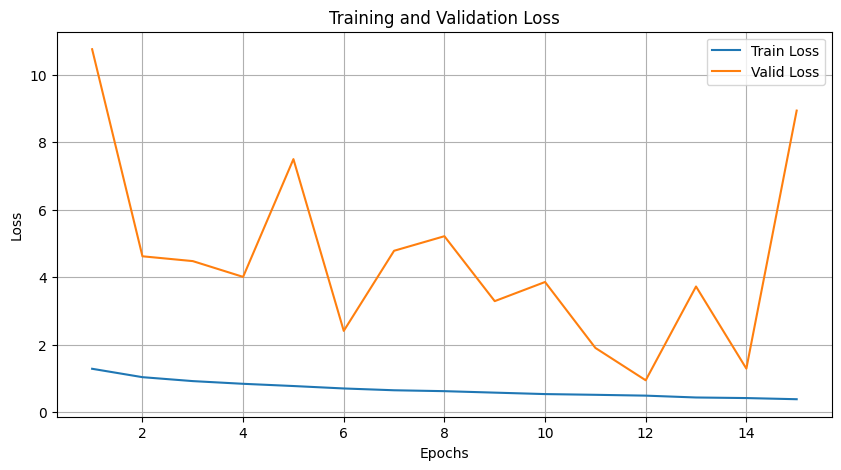

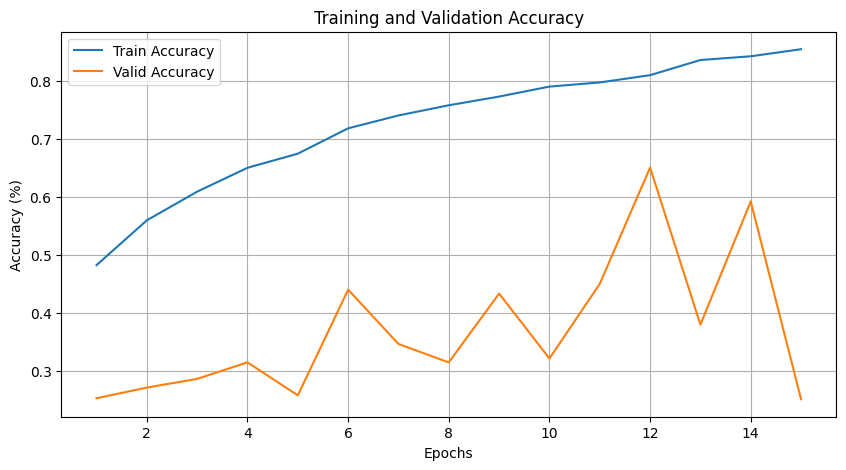

Training completed.


In [ ]:
# Extract training and validation metrics from the history object
train_losses = history.history['loss']
valid_losses = history.history['val_loss']
train_accuracies = history.history['accuracy']
valid_accuracies = history.history['val_accuracy']

num_epochs = len(train_losses)

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), valid_accuracies, label='Valid Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

print("Training completed.")

In [ ]:
from tensorflow.keras.models import load_model
best_model = load_model('/content/drive/MyDrive/cataract_data/best_model_2.keras')

# Evaluate the model on the test set
evaluation = best_model.evaluate(test_generator)

print("Test Loss:", evaluation[0])
print("Test Accuracy:", evaluation[1])

predictions = best_model.predict(test_generator)
y_true = test_generator.classes
y_pred = np.argmax(predictions, axis=1)

from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# Print confusion matrix
print(confusion_matrix(y_true, y_pred))

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 128s 12s/step - accuracy: 0.8079 - loss: 0.5056
Test Loss: 0.9257671236991882
Test Accuracy: 0.6339434385299683
10/10 ━━━━━━━━━━━━━━━━━━━━ 124s 12s/step
              precision    recall  f1-score   support

 hypermature       0.78      0.99      0.87       150
    immature       0.47      0.87      0.61       150
      mature       0.70      0.34      0.46       151
      normal       0.89      0.33      0.49       150

    accuracy                           0.63       601
   macro avg       0.71      0.63      0.61       601
weighted avg       0.71      0.63      0.61       601

[[148   2   0   0]
 [  7 131  10   2]
 [ 16  79  52   4]
 [ 19  69  12  50]]


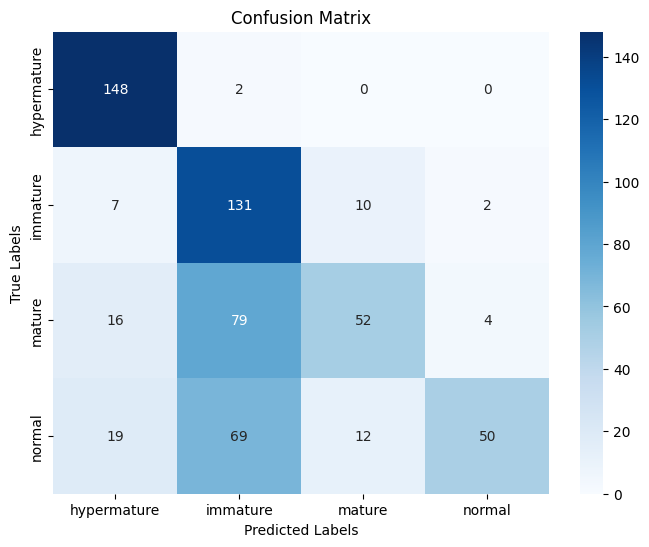

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

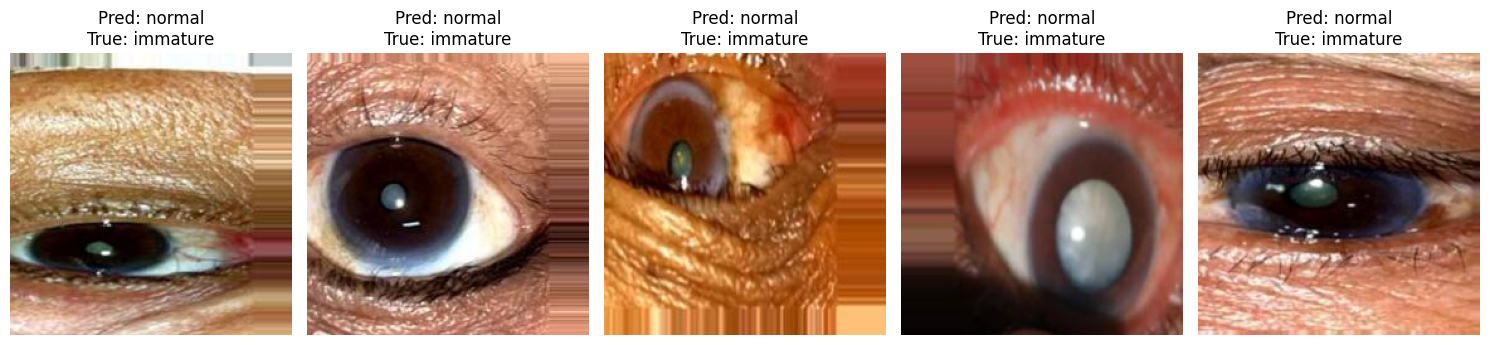

In [ ]:
images, labels = next(test_generator)

predicted_labels = np.argmax(predictions, axis=1)

num_images = 5

fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(15, 5))

for i in range(num_images):
    axes[i].imshow(images[i])
    axes[i].axis('off')
    axes[i].set_title(f"Pred: {class_names[predicted_labels[i]]}\nTrue: {class_names[np.argmax(labels[i])]}")

plt.tight_layout()
plt.show()

In [ ]:
# prompt: predict Correct vs. Incorrect list

# Get predicted labels and true labels for the test set
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

# Create a list to store the results
results = []

# Iterate through the predictions and true labels
for i in range(len(y_pred)):
    predicted_class = class_names[y_pred[i]]
    true_class = class_names[y_true[i]]

    # Check if the prediction is correct
    correct = predicted_class == true_class

    # Append the results to the list
    results.append({'prediction': predicted_class, 'true': true_class, 'correct': correct})

# Print the results in a formatted way
print("Prediction vs. True Label:")
for item in results:
  print(f"Predicted: {item['prediction']}, True: {item['true']}, Correct: {item['correct']}")

Prediction vs. True Label:
Predicted: normal, True: normal, Correct: True
Predicted: normal, True: normal, Correct: True
Predicted: normal, True: normal, Correct: True
Predicted: normal, True: normal, Correct: True
Predicted: normal, True: normal, Correct: True
Predicted: normal, True: normal, Correct: True
Predicted: normal, True: normal, Correct: True
Predicted: normal, True: normal, Correct: True
Predicted: normal, True: normal, Correct: True
Predicted: normal, True: normal, Correct: True
Predicted: normal, True: normal, Correct: True
Predicted: normal, True: normal, Correct: True
Predicted: normal, True: normal, Correct: True
Predicted: normal, True: normal, Correct: True
Predicted: normal, True: normal, Correct: True
Predicted: normal, True: normal, Correct: True
Predicted: normal, True: normal, Correct: True
Predicted: normal, True: normal, Correct: True
Predicted: normal, True: normal, Correct: True
Predicted: normal, True: normal, Correct: True
Predicted: normal, True: normal, 

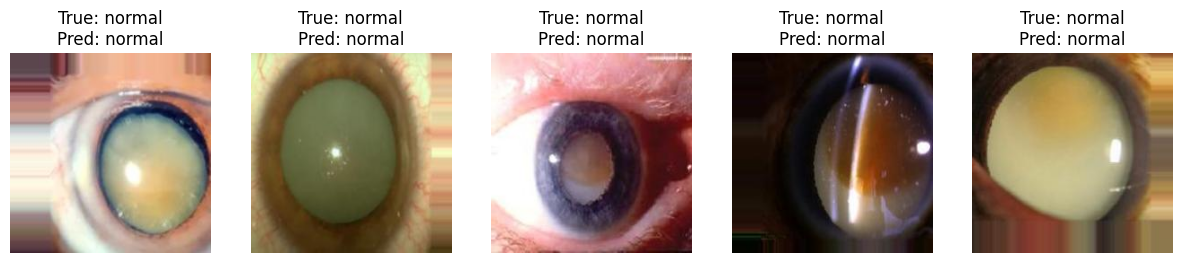

In [ ]:
images, labels = next(test_generator)

predicted_labels = np.argmax(predictions, axis=1)

num_images_to_display = 5

fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 5))

for i in range(num_images_to_display):
    ax = axes[i]
    image = images[i]
    true_label = class_names[np.argmax(labels[i])]  # Get true class label
    predicted_label = class_names[predicted_labels[i]]

    ax.imshow(image)
    ax.set_title(f"True: {true_label}\nPred: {predicted_label}")
    ax.axis('off')

plt.show()